In [1]:
# !git clone https://github.com/cpwan/RLOR
# %cd RLOR
%cd ..
%pwd

/raid/students/jeryl/RLOR/RLOR-ASAP


'/raid/students/jeryl/RLOR/RLOR-ASAP'

In [2]:
import numpy as np
import torch
import gym
import sys
import os

In [3]:
from models.attention_model_wrapper import Agent
device = 'cuda'
ckpt_path = '/data/students/jeryl/RLOR/RLOR-ASAP/runs/cvrp-v0__ppo_or__42__1744547570/ckpt/2441.pt'
agent = Agent(device=device, name='cvrp').to(device)
agent.load_state_dict(torch.load(ckpt_path))

/tmp/ipykernel_2411195/2471384833.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(ckpt_path))


<All keys matched successfully>

In [4]:
project_root = '/data/students/jeryl/RLOR/RLOR-ASAP'
sys.path.append(project_root)

# Define our agent

In [5]:
from models.attention_model_wrapper import Agent
device = 'cuda'
ckpt_path = '/data/students/jeryl/RLOR/RLOR-ASAP/runs/cvrp-v0__ppo_or__42__1744547570/ckpt/2441.pt'
agent = Agent(device=device, name='cvrp').to(device)
agent.load_state_dict(torch.load(ckpt_path))

/tmp/ipykernel_2411195/2471384833.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.load_state_dict(torch.load(ckpt_path))


<All keys matched successfully>

# Define our environment
## CVRP
Given a depot, n nodes with their demands, and the capacity of the vehicle, 
find the shortest path that fulfills the demand of every node.


In [6]:
from wrappers.syncVectorEnvPomo import SyncVectorEnv
from wrappers.recordWrapper import RecordEpisodeStatistics

env_id = 'cvrp-v0'
env_entry_point = 'envs.cvrp_vector_env:CVRPVectorEnv'
seed = 0

gym.envs.register(
    id=env_id,
    entry_point=env_entry_point,
)

def make_env(env_id, seed, cfg={}):
    def thunk():
        env = gym.make(env_id, **cfg)
        env = RecordEpisodeStatistics(env)
        env.seed(seed)
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

envs = SyncVectorEnv([make_env(env_id, seed, dict(n_traj=50))])

FINAL ACTION MASK
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


/data/students/jeryl/anaconda3/envs/pytorch251/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (50, 51)
  logger.warn(
/data/students/jeryl/anaconda3/envs/pytorch251/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:31: UserWarning: WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (50, 2)
  logger.warn(


# Inference
We use the Multi-Greedy search strategy: running greedy sampling with different starting nodes

In [7]:
trajectories = []
agent.eval()
obs = envs.reset()
init_demand = obs['demand'].copy()
print(init_demand.shape)
init_end_time = obs['end_time'][0][0].copy()
init_end_time = init_end_time[1:].reshape(1, -1)
print(init_end_time.shape)
print(init_end_time)
cap_limit = 1.00
done = np.array([False])
while not done.all():
    # ALGO LOGIC: action logic
    with torch.no_grad():
        action, logits = agent(obs)
    if trajectories==[]: # Multi-greedy inference
        action = torch.arange(1, envs.n_traj + 1).repeat(1, 1)
    
    obs, reward, done, info = envs.step(action.cpu().numpy())
    trajectories.append(action.cpu().numpy())



/data/students/jeryl/anaconda3/envs/pytorch251/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/data/students/jeryl/anaconda3/envs/pytorch251/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/data/students/jeryl/anaconda3/envs/pytorch251/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'dict'>`
  logger.warn(


FINAL ACTION MASK
[False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]


KeyError: 'depot_wait_time'

In [ ]:
nodes_coordinates = np.vstack([obs['depot'],obs['observations'][0]])
final_return = info[0]['episode']['r']
best_traj = np.argmax(final_return)
resulting_traj = np.array(trajectories)[:,0,best_traj]
resulting_traj_with_depot = np.hstack([np.zeros(1,dtype = int),resulting_traj])

## Results

In [ ]:
print(f'A route of length {final_return[best_traj]}')
print('The route is:\n', resulting_traj_with_depot)

A route of length -118.85894775390625
The route is:
 [ 0 19 10  9  6 44  3 45  2  0 11 15 13  8 41 17 12  0 16 46 32  7 30 27
 23 38  0 22 40 24 47 39 28  0 20 29 43 48 21 31 25  0 42 37 49 33 34  5
  0 14 50 26  4 35 36  1  0 18  0]


### Display it in a 2d-grid
- Darker color means later steps in the route.
- We abuse the errorbar to show the relative size of demand at each customer.

In [ ]:
def compute_total_distance(coords, route):
    return sum(np.linalg.norm(coords[route[i]] - coords[route[i+1]]) for i in range(len(route)-1))

def compute_violations(demand, end_times, route, coords, capacity_limit=1.0):
    total_demand = 0
    capacity_violations = 0
    time_violations = 0
    current_time = 0

    for i in range(1, len(route)):
        prev_node = route[i - 1]
        curr_node = route[i]

        # Distance = travel time (assuming 1 unit = 1 time unit)
        travel_time = np.linalg.norm(coords[prev_node] - coords[curr_node])
        current_time += travel_time

        if curr_node == 0:
            total_demand = 0
            current_time = 0  # reset time at depot
            continue

        cust_idx = curr_node - 1  # customer index (since depot is 0)
        total_demand += demand[cust_idx]

        if total_demand > capacity_limit + 1e-6:
            capacity_violations += 1

        if current_time > end_times[cust_idx]:
            time_violations += 1

    return capacity_violations, time_violations



def plot_multi_truck_route(coords, demand, end_times, route_with_depot, depot_idx=0):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import to_rgba
    from matplotlib.cm import get_cmap

    fig, ax = plt.subplots(figsize=(10, 10))

    # Split the route into segments between depots
    segments = []
    current_segment = []

    for node in route_with_depot:
        current_segment.append(node)
        if node == depot_idx and len(current_segment) > 1:
            segments.append(current_segment)
            current_segment = [depot_idx]


    # Choose a red-to-orange colormap
    cmap = get_cmap('autumn')  # Try 'OrRd' too for more depth

    n_routes = len(segments)
    route_colors = [cmap(i / (n_routes - 1)) for i in range(n_routes)]

    # Plot each segment cleanly
    for i, (segment, color) in enumerate(zip(segments, route_colors)):
        xy = coords[segment]
        x, y = xy[:, 0], xy[:, 1]
        ax.plot(x, y, '-o', color=color, label=f'Truck {i+1}', linewidth=2, markersize=4)

    # Plot depot as a large star
    depot_coord = coords[depot_idx]
    ax.plot(depot_coord[0], depot_coord[1], marker='*', color='black', markersize=20, label='Depot')

    # Flatten and insert depot values (0) for demand and end_times
    demand = demand.flatten()
    end_times = end_times.flatten()
    full_demand = np.insert(demand, 0, 0)
    full_end_times = np.insert(end_times, 0, 0)

    # Get node positions
    x_d, y_d = coords.T

    # Demand bars (grey)
    demand_height = full_demand / 4
    demand_bar = np.vstack([demand_height * 0, demand_height])
    ax.errorbar(x_d, y_d, demand_bar, fmt='None', elinewidth=2, color='grey', alpha=0.6, label='Demand (d)')

    # End time bars (black, slightly shifted right)
    endtime_height = full_end_times / full_end_times.max() / 4
    endtime_bar = np.vstack([endtime_height * 0, endtime_height])
    ax.errorbar(x_d + 0.005, y_d, endtime_bar, fmt='None', elinewidth=2, color='black', alpha=0.6, label='End Time (tw)')

    # Annotated text with light grey background
    for i, (x_pos, y_pos, d, t) in enumerate(zip(x_d, y_d, full_demand, full_end_times)):
        if i == depot_idx:
            continue
        label = f'd={d:.2f}\ntw={int(t)}'
        ax.text(
            x_pos + 0.01, y_pos + 0.01, label,
            fontsize=8,
            color='black',
            ha='left',
            va='bottom',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.6)
        )

    # Compute stats
    total_distance = compute_total_distance(coords, route_with_depot)
    cap_viol, time_viol = compute_violations(
        demand=init_demand.flatten(),
        end_times=init_end_time.flatten(),
        route=resulting_traj_with_depot,
        coords=nodes_coordinates,
        capacity_limit=cap_limit
    )

    # Display stats as text box in the plot
    stats_text = f"Total Distance: {total_distance:.2f}\nCapacity Violations: {cap_viol}\nTime Violations: {time_viol}"
    ax.text(
        0.03, 0.97, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8)
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('square')
    ax.set_title('Opt. Solution for a Capacitated Vehicle Routing Problem with Time Windows (CVRP-TW) using RLOR-ASAP')
    ax.legend(loc='upper right')
    ax.grid(True)
    plt.show()


/tmp/ipykernel_1712060/697094926.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('autumn')  # Try 'OrRd' too for more depth


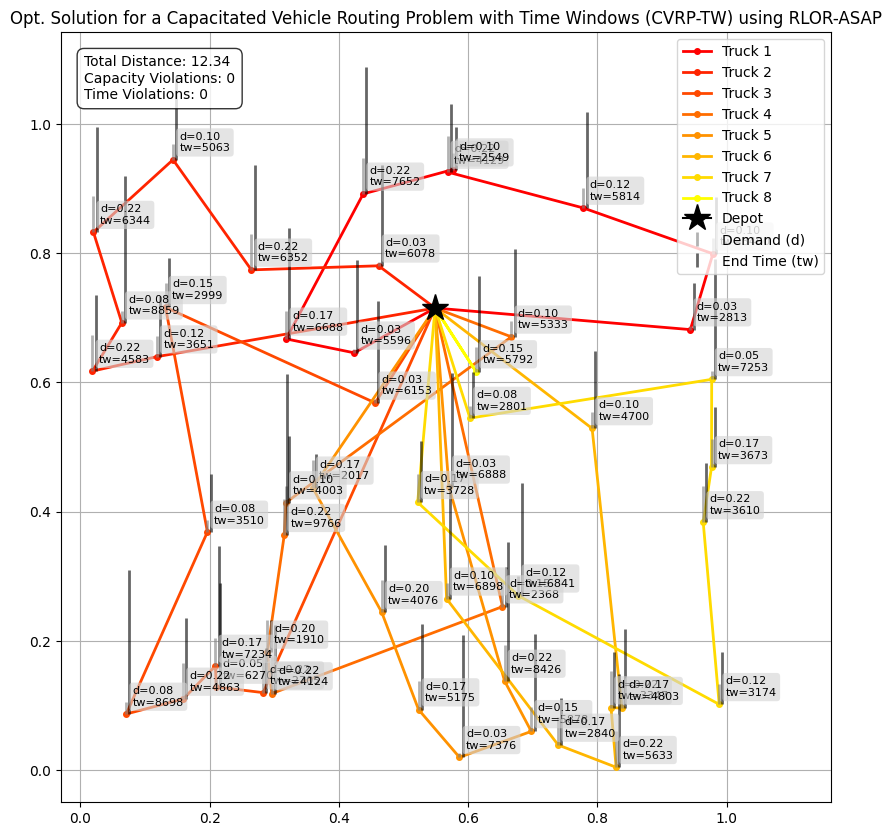

In [ ]:
plot_multi_truck_route(
    coords=nodes_coordinates,
    demand=init_demand,          # shape: (1, 50)
    end_times=init_end_time,    # shape: (1, 50)
    route_with_depot=resulting_traj_with_depot
)



In [ ]:
def compute_total_distance(coords, route):
    return sum(np.linalg.norm(coords[route[i]] - coords[route[i+1]]) for i in range(len(route)-1))

def compute_violations(demand, end_times, route, coords, capacity_limit=1.0):
    total_demand = 0
    capacity_violations = 0
    time_violations = 0
    current_time = 0

    for i in range(1, len(route)):
        prev_node = route[i - 1]
        curr_node = route[i]

        # Distance = travel time (assuming 1 unit = 1 time unit)
        travel_time = np.linalg.norm(coords[prev_node] - coords[curr_node])
        current_time += travel_time

        if curr_node == 0:
            total_demand = 0
            current_time = 0  # reset time at depot
            continue

        cust_idx = curr_node - 1  # customer index (since depot is 0)
        total_demand += demand[cust_idx]

        if total_demand > capacity_limit + 1e-6:
            capacity_violations += 1

        if current_time > end_times[cust_idx]:
            time_violations += 1

    return capacity_violations, time_violations



def plot_multi_truck_route(coords, demand, end_times, route_with_depot, depot_idx=0):
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import to_rgba
    from matplotlib.cm import get_cmap

    fig, ax = plt.subplots(figsize=(11, 11))

    # Split the route into segments between depots
    segments = []
    current_segment = []

    for node in route_with_depot:
        current_segment.append(node)
        if node == depot_idx and len(current_segment) > 1:
            segments.append(current_segment)
            current_segment = [depot_idx]


    # Choose a red-to-orange colormap
    cmap = get_cmap('autumn')  # Try 'OrRd' too for more depth

    n_routes = len(segments)
    route_colors = [cmap(i / (n_routes - 1)) for i in range(n_routes)]

    for i, (segment, color) in enumerate(zip(segments, route_colors)):
        xy = coords[segment]
        x, y = xy[:, 0], xy[:, 1]

        # Compute route distance
        route_distance = compute_total_distance(coords, segment)

        # Compute load
        flat_demand = demand.flatten()
        route_demand = sum(flat_demand[node - 1] for node in segment if node != depot_idx)
        load_str = f"{route_demand:.2f}/{cap_limit:.1f}"

        ax.plot(
            x, y, '-o',
            color=color,
            linewidth=2,
            markersize=4,
            label=f"Truck {i+1} | dist={route_distance:.2f} | load={load_str}"
        )


    # Plot depot as a large star
    depot_coord = coords[depot_idx]
    ax.plot(depot_coord[0], depot_coord[1], marker='*', color='black', markersize=20, label='Depot')

    # Flatten and insert depot values (0) for demand and end_times
    demand = demand.flatten()
    end_times = end_times.flatten()
    full_demand = np.insert(demand, 0, 0)
    full_end_times = np.insert(end_times, 0, 0)

    # Get node positions
    x_d, y_d = coords.T

    # Demand bars (grey)
    demand_height = full_demand / 4
    demand_bar = np.vstack([demand_height * 0, demand_height])
    ax.errorbar(x_d, y_d, demand_bar, fmt='None', elinewidth=2, color='grey', alpha=0.6, label='Demand (d)')

    # End time bars (black, slightly shifted right)
    endtime_height = full_end_times / full_end_times.max() / 4
    endtime_bar = np.vstack([endtime_height * 0, endtime_height])
    ax.errorbar(x_d + 0.005, y_d, endtime_bar, fmt='None', elinewidth=2, color='black', alpha=0.6, label='End Time (tw)')

    # Annotated text with light grey background
    for i, (x_pos, y_pos, d, t) in enumerate(zip(x_d, y_d, full_demand, full_end_times)):
        if i == depot_idx:
            continue
        label = f'd={d:.2f}\ntw={int(t)}'
        ax.text(
            x_pos + 0.01, y_pos + 0.01, label,
            fontsize=8,
            color='black',
            ha='left',
            va='bottom',
            bbox=dict(facecolor='lightgrey', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.6)
        )

    # Compute stats
    total_distance = compute_total_distance(coords, route_with_depot)
    cap_viol, time_viol = compute_violations(
        demand=init_demand.flatten(),
        end_times=init_end_time.flatten(),
        route=resulting_traj_with_depot,
        coords=nodes_coordinates,
        capacity_limit=cap_limit
    )

    # Display stats as text box in the plot
    stats_text = f"Total Distance: {total_distance:.2f}\nCapacity Violations: {cap_viol}\nTime Violations: {time_viol}"
    ax.text(
        0.03, 0.97, stats_text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5', alpha=0.8)
    )

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('square')
    ax.set_title('Optimal Solution for a Capacitated Vehicle Routing Problem with Time Windows (CVRP-TW) using RLOR-ASAP')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True)
    plt.show()


/tmp/ipykernel_1712060/242659183.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('autumn')  # Try 'OrRd' too for more depth


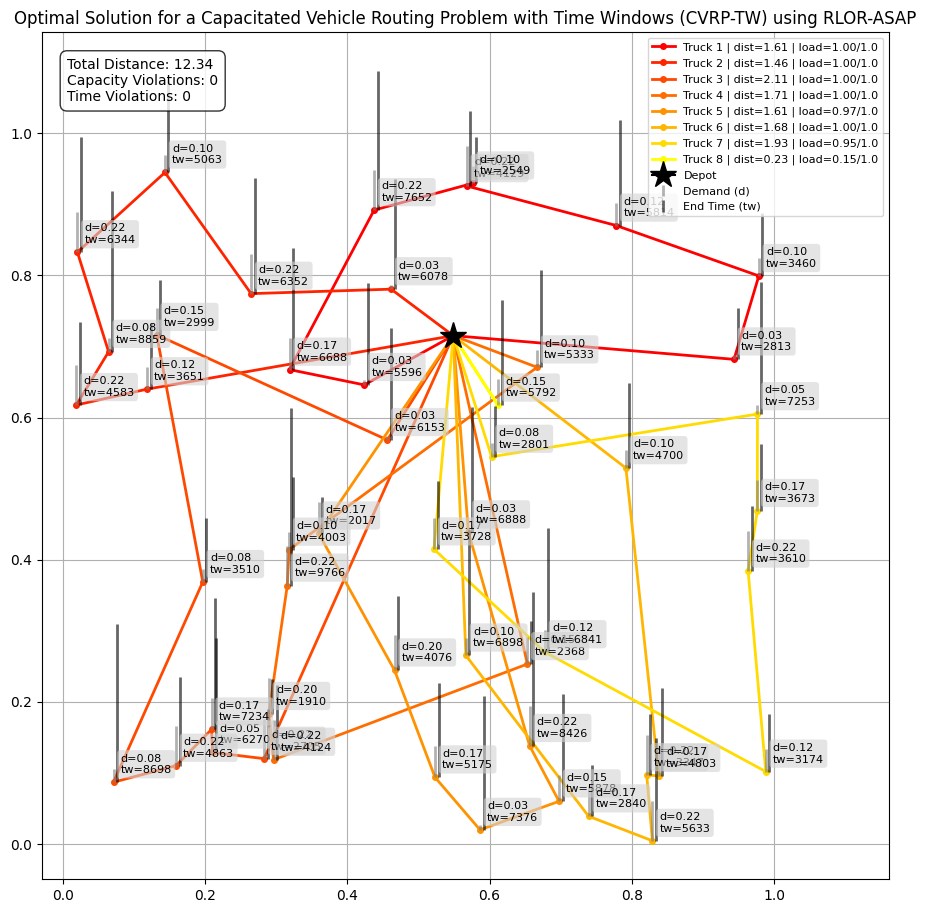

In [ ]:
plot_multi_truck_route(
    coords=nodes_coordinates,
    demand=init_demand,          # shape: (1, 50)
    end_times=init_end_time,    # shape: (1, 50)
    route_with_depot=resulting_traj_with_depot
)